#### Imports and Basic Set Up

In [ ]:
import os
import requests
from zipfile import ZipFile
from google.colab import drive
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from concurrent.futures import ThreadPoolExecutor, as_completed
import random

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = "/content/drive/MyDrive/CS445/Project/Data"
os.makedirs(f"{base_path}/data/preprocessed", exist_ok=True)
os.makedirs(f"{base_path}/data/target_images", exist_ok=True)

print(f"Directories created under: {base_path}")


Directories created under: /content/drive/MyDrive/CS445/Project/Data


#### Download Dataset

In [ ]:
def download_and_extract(url, save_path, extract_to):
    # Download the dataset
    print(f"Downloading from {url}...")
    response = requests.get(url, stream=True)
    with open(save_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
    print(f"Downloaded and saved to {save_path}")

    # Extract the dataset
    print(f"Extracting {save_path}...")
    with ZipFile(save_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extraction completed to {extract_to}")

In [ ]:

coco_url = "http://images.cocodataset.org/zips/train2017.zip"
coco_save_path = f"{base_path}/data/tiles/train2017.zip"
download_and_extract(coco_url, coco_save_path, f"{base_path}/data/tiles")


Downloaded and saved to /content/drive/MyDrive/CS445/Project/Data/data/tiles/train2017.zip
Extracting /content/drive/MyDrive/CS445/Project/Data/data/tiles/train2017.zip...
Extraction completed to /content/drive/MyDrive/CS445/Project/Data/data/tiles


#### Summary of Downloads

In [ ]:

def summarize_directory(directory):
    print(f"Summary of {directory}:")
    for root, dirs, files in os.walk(directory):
        print(f"{len(files)} files in {root}")

summarize_directory(f"{base_path}/data/tiles")

Summary of /content/drive/MyDrive/CS445/Project/Data/data/tiles:
1 files in /content/drive/MyDrive/CS445/Project/Data/data/tiles
118287 files in /content/drive/MyDrive/CS445/Project/Data/data/tiles/train2017


In [ ]:
# Function to summarize files in a directory
def summarize_directory(directory):
    print(f"Summary of {directory}:")
    for root, dirs, files in os.walk(directory):
        print(f"Directory: {root}")
        print(f"Contains {len(files)} files")
        if files:
            print("Sample files:", files[:5])  # Display up to 5 sample files
        print("-" * 40)

# Run the function on the extracted tiles directory
summarize_directory(f"{base_path}/data/tiles")


Summary of /content/drive/MyDrive/CS445/Project/Data/data/tiles:
Directory: /content/drive/MyDrive/CS445/Project/Data/data/tiles
Contains 1 files
Sample files: ['train2017.zip']
----------------------------------------
Directory: /content/drive/MyDrive/CS445/Project/Data/data/tiles/train2017
Contains 118287 files
Sample files: ['000000147328.jpg', '000000414738.jpg', '000000281563.jpg', '000000063879.jpg', '000000531349.jpg']
----------------------------------------


In [ ]:
os.remove(f"{base_path}/data/tiles/train2017.zip")
print("ZIP file deleted to save space.")

ZIP file deleted to save space.


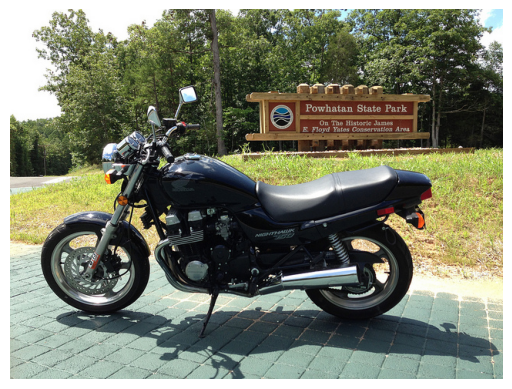

In [ ]:

# Load an image
sample_image_path = f"{base_path}/data/tiles/train2017/000000147328.jpg"
img = Image.open(sample_image_path)

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes for better visualization
plt.show()


### Data Preprocessing

Compute and store color information (e.g., average RGB, LAB, HSV values) for each tile image to enable efficient matching during mosaic generation.

In [ ]:

tiles_dir = f"{base_path}/data/tiles/train2017"
output_csv = f"{base_path}/data/preprocessed/tile_colors.csv"


In [ ]:

def compute_average_colors(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None

    # Compute average in RGB
    avg_rgb = np.mean(img, axis=(0, 1))

    # Convert to LAB and HSV
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    avg_lab = np.mean(img_lab, axis=(0, 1))

    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    avg_hsv = np.mean(img_hsv, axis=(0, 1))

    return os.path.basename(image_path), avg_rgb.tolist(), avg_lab.tolist(), avg_hsv.tolist()


def process_images_in_parallel(image_paths):
    data = []
    with ThreadPoolExecutor(max_workers=16) as executor:
        futures = {executor.submit(compute_average_colors, path): path for path in image_paths}
        for future in tqdm(as_completed(futures), total=len(futures)):
            result = future.result()
            if result is not None:
                data.append(result)
    return data


In [ ]:
image_paths = [os.path.join(tiles_dir, image_name) for image_name in os.listdir(tiles_dir)]

# Process images and compute average colors
print("Processing images in parallel...")
results = process_images_in_parallel(image_paths)

# Save results to CSV
df = pd.DataFrame(results, columns=["image_name", "avg_color_RGB", "avg_color_LAB", "avg_color_HSV"])


In [ ]:
df.to_csv(output_csv, index=False)
print(f"Color data saved to: {output_csv}")

Color data saved to: /content/drive/MyDrive/CS445/Project/Data/data/preprocessed/tile_colors.csv


In [ ]:
df.shape

(118287, 4)

#### Tile Quality Check

This step filters out corrupted or low-quality images based on brightness thresholds.

In [ ]:

def validate_tile_quality(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
    if img is None:
        return False
    img_small = cv2.resize(img, (50, 50), interpolation=cv2.INTER_AREA)  # Downscale to 50x50
    mean_brightness = np.mean(img_small)  # Calculate mean brightness
    return mean_brightness > 10


def validate_all_tiles_multithreaded(image_paths, max_workers=8):
    valid_images = []
    invalid_images = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(validate_tile_quality, path): path for path in image_paths}
        for future in tqdm(futures, desc="Validating tiles"):
            result = future.result()
            image_path = futures[future]
            image_name = os.path.basename(image_path)
            if result:
                valid_images.append(image_name)
            else:
                invalid_images.append(image_name)

    return valid_images, invalid_images

In [ ]:
# Run the optimized tile validation
valid_images, invalid_images = validate_all_tiles_multithreaded(image_paths)
print(f"Valid images: {len(valid_images)}, Invalid images: {len(invalid_images)}")

Validating tiles: 100%|██████████| 118287/118287 [1:23:37<00:00, 23.57it/s]

Valid images: 118271, Invalid images: 16


In [ ]:
valid_images_csv = f"{base_path}/data/preprocessed/valid_images.csv"
invalid_images_csv = f"{base_path}/data/preprocessed/invalid_images.csv"

# Save valid images
valid_images_df = pd.DataFrame(valid_images, columns=["image_name"])
valid_images_df.to_csv(valid_images_csv, index=False)
print(f"Valid images saved to: {valid_images_csv}")

# Save invalid images
invalid_images_df = pd.DataFrame(invalid_images, columns=["image_name"])
invalid_images_df.to_csv(invalid_images_csv, index=False)
print(f"Invalid images saved to: {invalid_images_csv}")

Valid images saved to: /content/drive/MyDrive/CS445/Project/Data/data/preprocessed/valid_images.csv
Invalid images saved to: /content/drive/MyDrive/CS445/Project/Data/data/preprocessed/invalid_images.csv


In [ ]:
valid_images = pd.read_csv("/content/drive/MyDrive/CS445/Project/Data/data/preprocessed/valid_images.csv")

In [ ]:
valid_images.shape

(118271, 1)

In [ ]:
invalid_images = pd.read_csv("/content/drive/MyDrive/CS445/Project/Data/data/preprocessed/invalid_images.csv")

In [ ]:
invalid_images.shape

(16, 1)

In [ ]:
def compute_brightness_subsets(images, tiles_dir, sample_size=1000):
    brightness = []
    sampled_images = random.sample(images, min(sample_size, len(images)))  # Randomly sample
    for image_name in sampled_images:
        image_path = os.path.join(tiles_dir, image_name)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            brightness.append(np.mean(img) / 255.0)  # Normalize brightness to range 0–1
    return brightness


In [ ]:
valid_image = valid_images['image_name'].tolist()
invalid_image = invalid_images['image_name'].tolist()

In [ ]:
# Parameters
sample_size = 1000  # Number of images to sample from each set

# Compute brightness for valid and invalid images
print("Computing brightness for valid images...")
valid_brightness = compute_brightness_subsets(valid_image, tiles_dir, sample_size)
print("Complete")

print("Computing brightness for invalid images...")
invalid_brightness = compute_brightness_subsets(invalid_image, tiles_dir, sample_size)
print("Complete")


Computing brightness for valid images...
Complete
Computing brightness for invalid images...
Complete


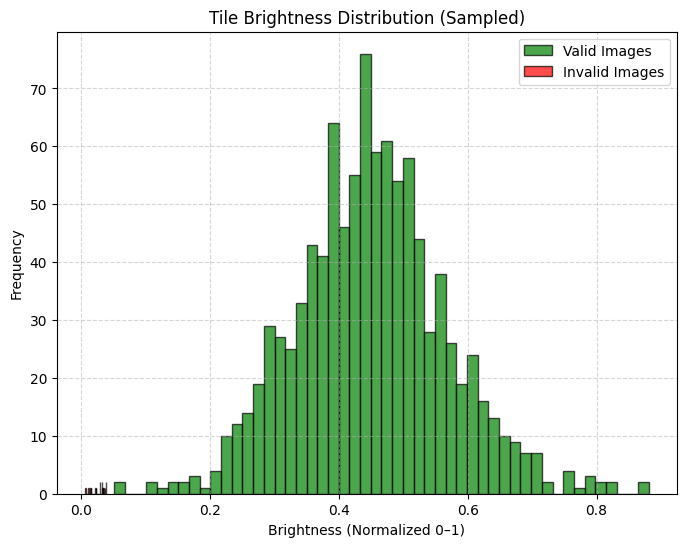

In [ ]:
# Plot the brightness distribution
def plot_brightness(valid_brightness, invalid_brightness):
    plt.figure(figsize=(8, 6))
    plt.hist(valid_brightness, bins=50, alpha=0.7, label="Valid Images", color="green", edgecolor='black')
    plt.hist(invalid_brightness, bins=50, alpha=0.7, label="Invalid Images", color="red", edgecolor='black')
    plt.xlabel("Brightness (Normalized 0–1)")
    plt.ylabel("Frequency")
    plt.title("Tile Brightness Distribution (Sampled)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

plot_brightness(valid_brightness, invalid_brightness)


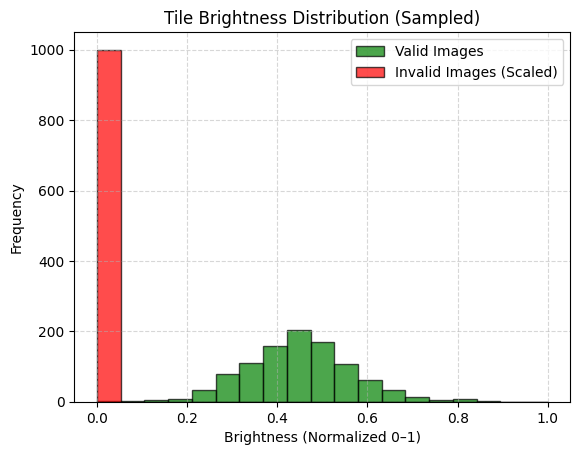

In [ ]:
plt.hist(valid_brightness, bins=np.linspace(0, 1, 20), alpha=0.7, label="Valid Images", color="green", edgecolor="black")
plt.hist(invalid_brightness, bins=np.linspace(0, 1, 20), alpha=0.7, label="Invalid Images (Scaled)", color="red", edgecolor="black", weights=np.ones(len(invalid_brightness)) * (len(valid_brightness) / len(invalid_brightness)))
plt.xlabel("Brightness (Normalized 0–1)")
plt.ylabel("Frequency")
plt.title("Tile Brightness Distribution (Sampled)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

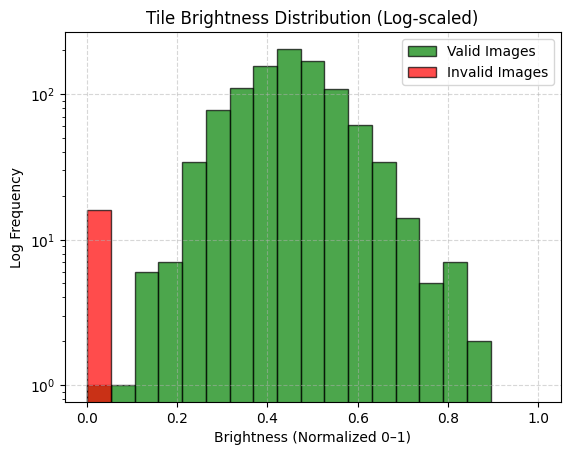

In [ ]:
plt.hist(valid_brightness, bins=np.linspace(0, 1, 20), alpha=0.7, label="Valid Images", color="green", edgecolor="black")
plt.hist(invalid_brightness, bins=np.linspace(0, 1, 20), alpha=0.7, label="Invalid Images", color="red", edgecolor="black")
plt.xlabel("Brightness (Normalized 0–1)")
plt.ylabel("Log Frequency")
plt.title("Tile Brightness Distribution (Log-scaled)")
plt.yscale("log")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [ ]:
print('Process Complete')